In [1]:
%matplotlib widget
# %load_ext autoreload
# %autoreload 2
from fig12code import *

In [2]:
pd.read_csv('data/data_melling_2024.csv',index_col=False).head()

,lake_id,dist_along_track_m,lon,lat,surrf_2024,manual,Z_green,Z_red,Z_corrected_dem
0,1,1306.5,-49.138228,67.080167,0.0,NaN,NaN,NaN,NaN
1,1,1301.5,-49.138216,67.080212,0.0,NaN,NaN,NaN,NaN
2,1,1296.5,-49.138203,67.080256,0.0,NaN,NaN,NaN,NaN
3,1,1291.5,-49.138190,67.080301,0.0,NaN,NaN,NaN,NaN
4,1,1286.5,-49.138177,67.080345,0.0,NaN,NaN,NaN,NaN


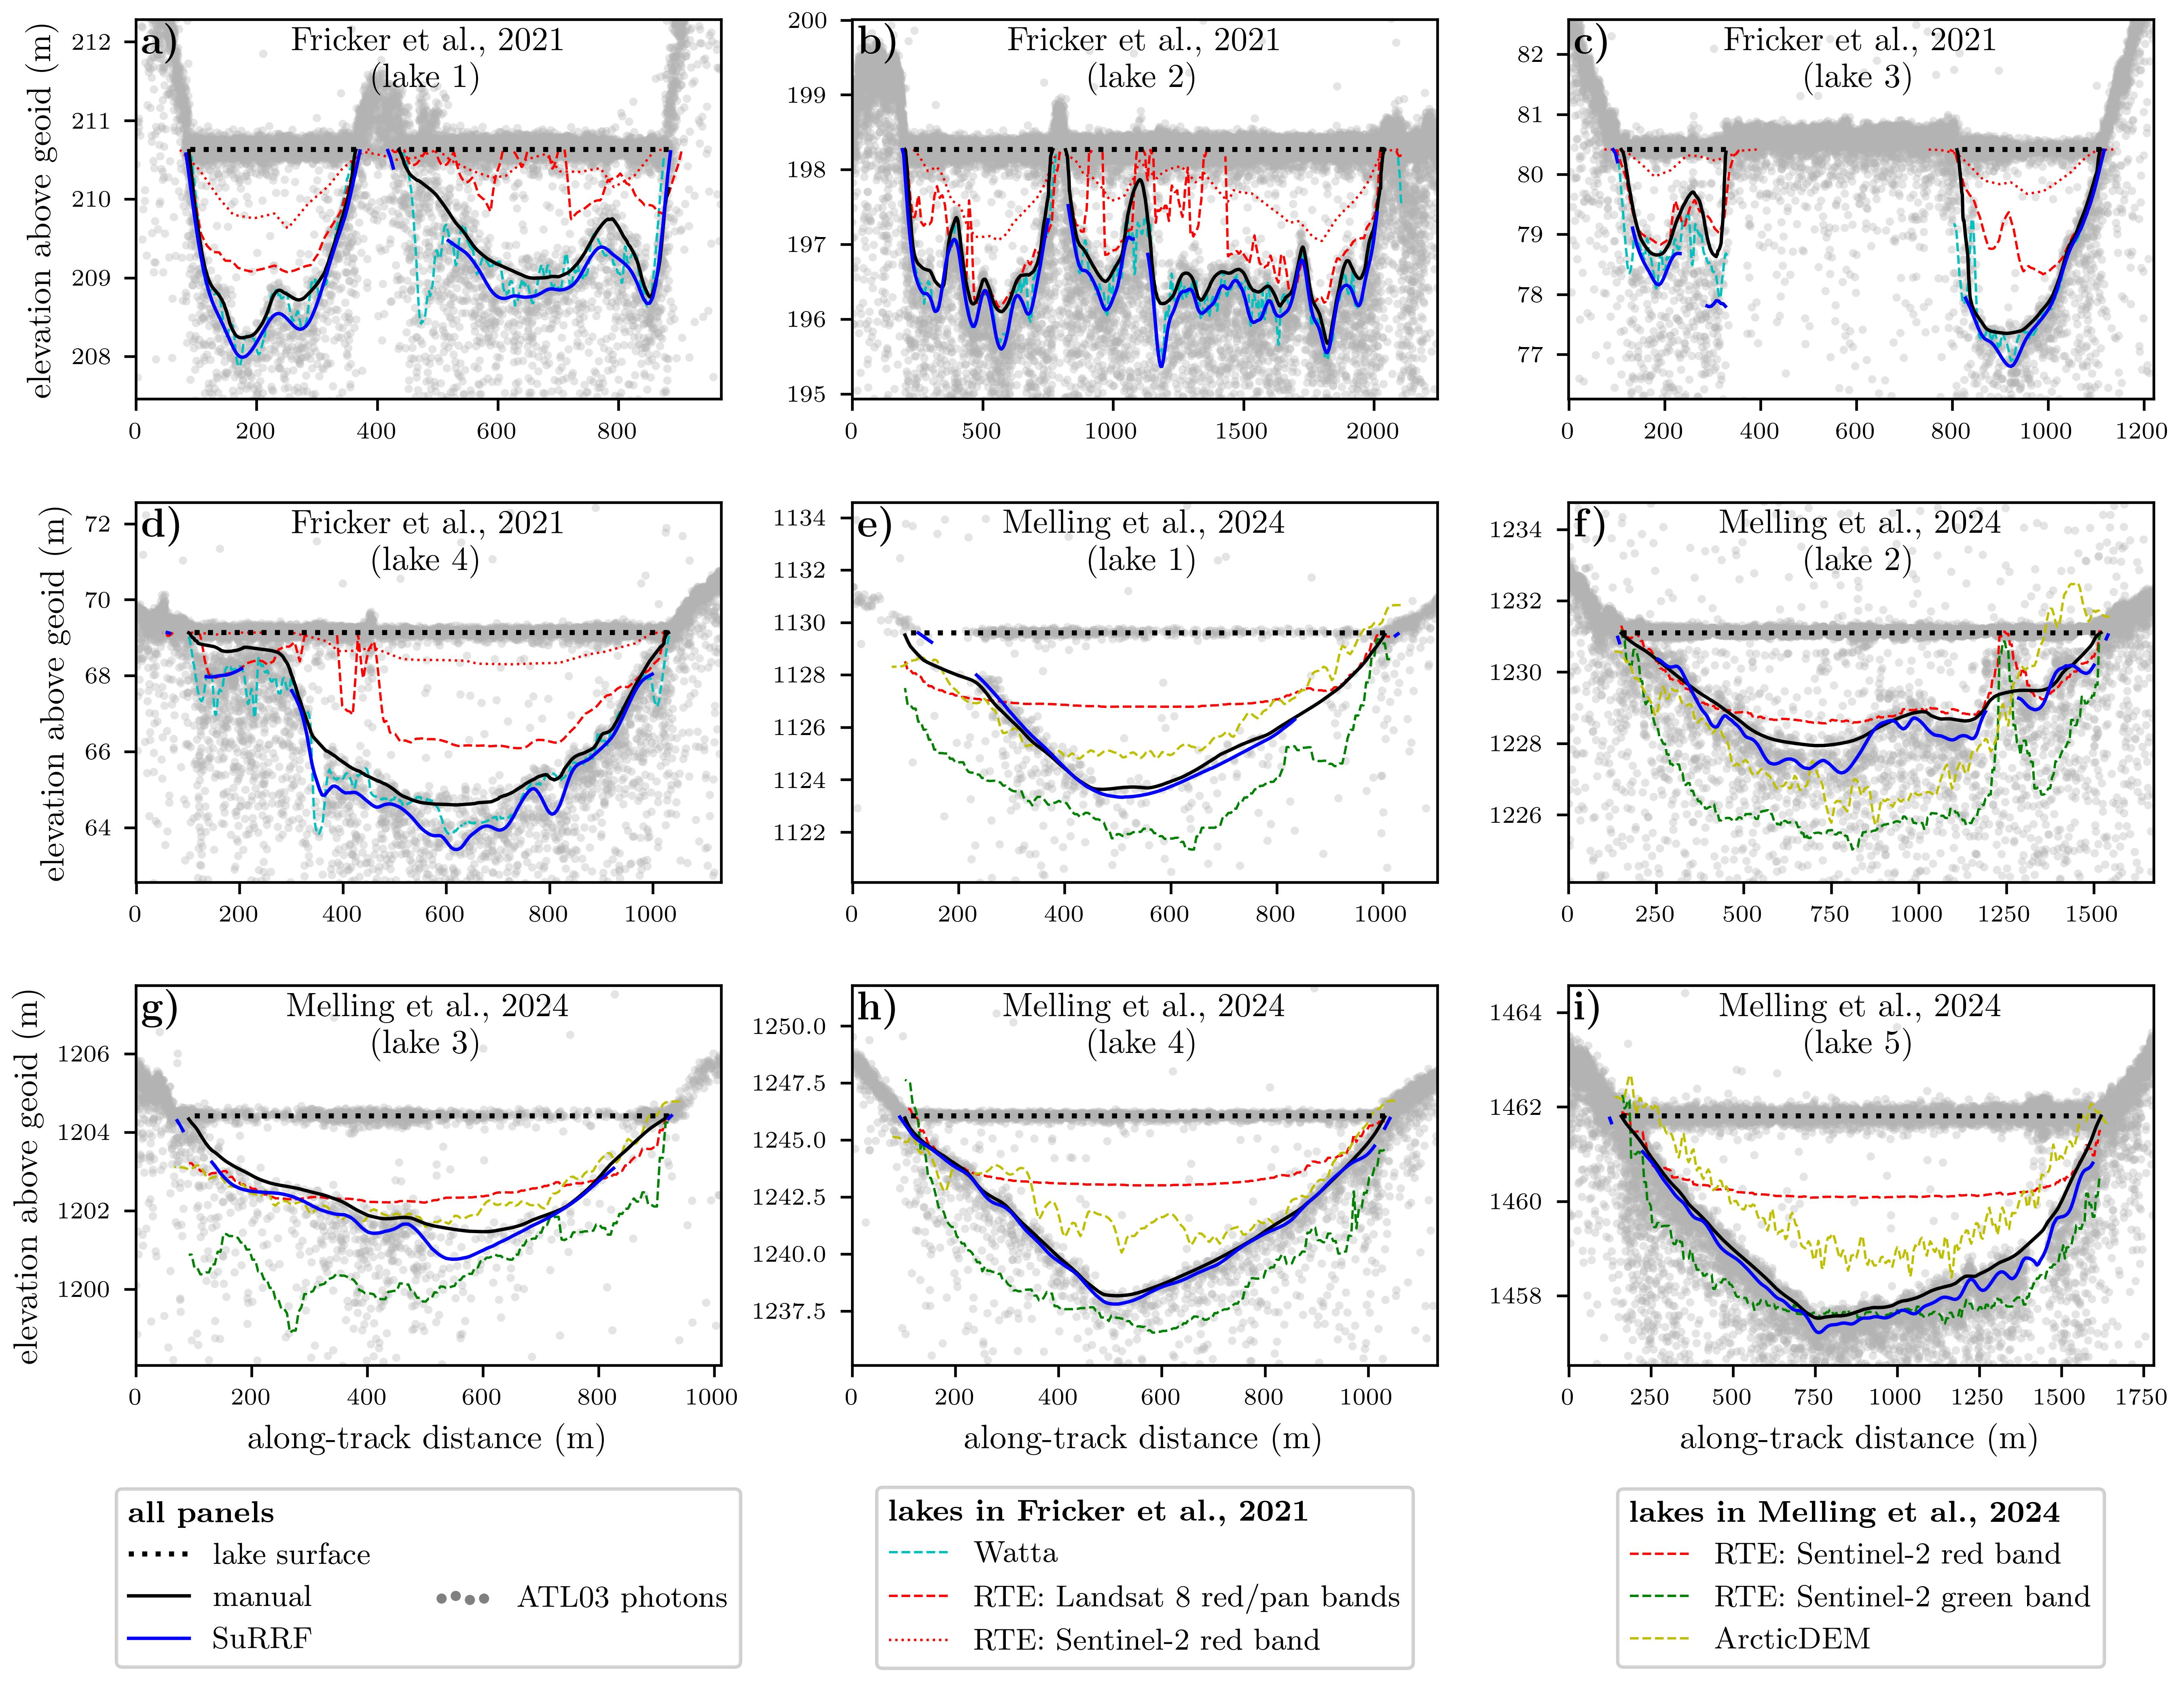

In [3]:
# input data
df_melling = pd.read_csv('data/data_melling_2024.csv',index_col=False)
df_fricker = pd.read_csv('data/data_fricker_2021.csv',index_col=False)

# some plotting settings
plotname = '../figures/fig12-comparison_manual_estimates.jpg'
plt.rcParams.update({
    'font.size': 7,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

# make the figure and axes
#fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)

fig = plt.figure(figsize=[9,7])
gs = fig.add_gridspec(ncols=3, nrows=11)
axs = []
for i in range(9):
    axs.append(fig.add_subplot(gs[3*int(i/3):3*int(i/3)+3, i%3]))
for i in range(3):
    axs.append(fig.add_subplot(gs[9:, i]))

ref_idx = 1.336
# loop though all the lakes
for iplot, ilake in enumerate(np.hstack((np.arange(1,5), np.arange(1,6)))):
    
    ax = axs[iplot]
    source = 'fricker' if iplot < 4 else 'melling'
    source_txt = 'Fricker et al., 2021' if source=='fricker' else 'Melling et al., 2024'
    dfm = df_fricker if source=='fricker' else df_melling
    lake_file_name = 'data/lake_amery_fricker_%i.h5' % ilake if source=='fricker' else 'data/lake_greenland_melling_%i.h5' % ilake
    
    selector = dfm.lake_id == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5(lake_file_name))
    hsurf = lk.surface_elevation
    df = lk.photon_data
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    
    afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    xmin = dfi.dist_along_track_m[(dfi.manual>0) & ~np.isnan(dfi.manual)].min()
    xmax = dfi.dist_along_track_m[(dfi.manual>0) & ~np.isnan(dfi.manual)].max()
    xrange = xmax-xmin
    fac = 0.11
    xlim = np.array([xmin-fac*xrange, xmax+fac*xrange])
    df = df[(df.xatc > xlim[0]) & (df.xatc < xlim[1])].copy()
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    xoff = df.xatc.min()
    df.xatc -= xoff
    dfi.dist_along_track_m -= xoff
    xlim -= xoff
    
    dfi.loc[dfi.surrf_2024==0, 'surrf_2024'] = np.nan
    dfi.loc[dfi.manual==0, 'manual'] = np.nan
    ax.scatter(df.xatc[~afterpulse], df.h[~afterpulse], s=6, color=[0.7]*3, alpha=0.35, edgecolors='none')
    p_photons = ax.scatter([-999]*4, [-999]*4, s=4, color='gray', label='ATL03 photons')
    p_manual, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.manual, color='k', label='manual', lw=1, zorder=10)
    p_surrf, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.surrf_2024, color='b', label='SuRRF', lw=1, zorder=11)

    if source == 'fricker':
        dfi.loc[dfi.RTE_Landsat8_red_pan==0, 'RTE_Landsat8_red_pan'] = np.nan
        dfi.loc[dfi.RTE_Sentinel2_red==0, 'RTE_Sentinel2_red'] = np.nan
        p_watta, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.watta, color='c', ls='--', label='Watta', lw=0.7)
        p_l8, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.RTE_Landsat8_red_pan, color='r', ls='--', label='RTE: Landsat 8 red/pan bands', lw=0.7)
        p_s2, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.RTE_Sentinel2_red, color='r', ls=':', label='RTE: Sentinel-2 red band', lw=0.7)
        plotted_vals = dfi[['manual', 'surrf_2024', 'watta', 'RTE_Landsat8_red_pan', 'RTE_Sentinel2_red']]

    if source == 'melling':
        p_red, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Z_red, color='r', ls='--', label='RTE: Sentinel-2 red band', lw=0.7)
        p_green, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Z_green, color='g', ls='--', label='RTE: Sentinel-2 green band', lw=0.7)
        p_dem, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Z_corrected_dem, color='y', ls='--', label='ArcticDEM', lw=0.7)
        plotted_vals = dfi[['manual', 'surrf_2024', 'Z_red', 'Z_green', 'Z_corrected_dem']]
    
    surf = np.ones_like(dfi.manual)*hsurf
    surf[(dfi.manual==0) | np.isnan(dfi.manual)] = np.nan
    p_surface, = ax.plot(dfi.dist_along_track_m, surf, 'k:', label='lake surface')
    ax.set_xlim(xlim)
    ax.set_ylim([hsurf-1.15*plotted_vals.max().max(), hsurf+0.6*plotted_vals.max().max()])
    ax.ticklabel_format(useOffset=False, style='plain')
    if iplot%3==0:
        ax.set_ylabel('elevation above geoid (m)', fontsize=10)
    if int(iplot/3) == 2:
        ax.set_xlabel('along-track distance (m)', fontsize=10)
    # if iplot==8:
    #     ax.legend(handles=[p_manual, p_surrf], ncols=2, loc='lower right')

    ax.text(0.5, 0.98, '%s\n(lake %s)'%(source_txt,ilake),transform=ax.transAxes,ha='center',va='top', fontsize=10)
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + iplot), transform=ax.transAxes, ha='left', va='top', fontsize=12)

# legends
empty_ = ax.scatter([],[],s=1,alpha=0,label=' ')

hdls = [[p_surface, p_manual, p_surrf, empty_, p_photons, empty_], [p_watta, p_l8, p_s2], [p_red, p_green, p_dem]]
tits = [r'\textbf{all panels}', r'\textbf{lakes in Fricker et al., 2021}', r'\textbf{lakes in Melling et al., 2024}']
for i in range(3):
    ax = axs[9+i]
    ax.axis('off')
    ncols = 2 if i==0 else 1
    leg = ax.legend(handles=hdls[i], ncols=ncols, loc='center', scatterpoints=4, fontsize=9, title=tits[i], title_fontproperties={'size': 9})
    leg._legend_box.align = "left"
    ax.add_artist(leg)

fig.tight_layout(pad=0.5)

# save the figure and show plot
plt.close(fig)
# display(fig)
fig.savefig(plotname, dpi=600)
display(Image(plotname))

## Old figure for initial submission

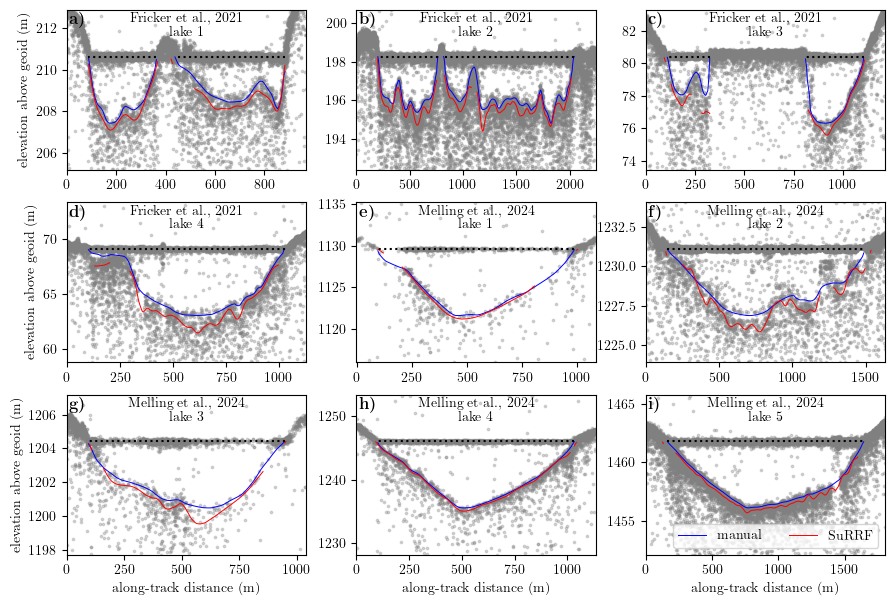

In [4]:
# input data
dfm = pd.read_csv('data/raw/manual_estimates.csv',index_col=False)
lakefns = {
    1: 'data/lake_amery_fricker_1.h5',
    2: 'data/lake_amery_fricker_2.h5',
    3: 'data/lake_amery_fricker_3.h5',
    4: 'data/lake_amery_fricker_4.h5',
    5: 'data/lake_greenland_melling_1.h5',
    6: 'data/lake_greenland_melling_2.h5',
    7: 'data/lake_greenland_melling_3.h5',
    8: 'data/lake_greenland_melling_4.h5',
    9: 'data/lake_greenland_melling_5.h5'
}

# some plotting settings
plotname = '../figures/fig12-comparison_manual_estimates.jpg'
plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})
conf_threshold = 0.3

# make the figure and axes
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs= axs.flatten()

dfm['surrf_2024'] = np.nan # initialize column for surrf
dfds = []
# loop though all the lakes
for ilake in np.unique(dfm.pond):
    ax = axs[ilake-1]
    selector = dfm.pond == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5(lakefns[ilake]))
    hsurf = lk.surface_elevation
    surf = np.ones_like(dfi.manual)*hsurf
    surf[dfi.manual==0] = np.nan
    df = lk.photon_data
    dfd = lk.depth_data.sort_values(by='lat')
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth=depth*1.336
    depth_interp = np.interp(dfi.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfm.loc[selector, 'surrf_2024'] = depth_interp
    dfd['surrf'] = depth
    dfd['manual'] = np.interp(dfd.lat, dfi.lat, dfi.manual, left=np.nan, right=np.nan)
    dfd['lake_id'] = ilake
    dfd['granule_id'] = dfi.granule_id.iloc[0]
    dfd['gtx'] = dfi.gtx.iloc[0]
    dfd['manual_source'] = dfi.source.iloc[0]
    dfds.append(dfd)

    dfd.loc[(dfd.conf < conf_threshold), 'depth'] = np.nan
    afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    xmin = dfd.xatc[(dfd.manual>0) & ~np.isnan(dfd.manual)].min()
    xmax = dfd.xatc[(dfd.manual>0) & ~np.isnan(dfd.manual)].max()
    xrange = xmax-xmin
    fac = 0.11
    xlim = np.array([xmin-fac*xrange, xmax+fac*xrange])
    df = df[(df.xatc > xlim[0]) & (df.xatc < xlim[1])].copy()
    xoff = df.xatc.min()
    df.xatc -= xoff
    dfd.xatc -= xoff
    xlim -= xoff
    dfd.loc[dfd.depth==0, 'depth'] = np.nan
    dfd.loc[dfd.manual==0, 'manual'] = np.nan
    ax.scatter(df.xatc[~afterpulse], df.h[~afterpulse], s=3, c='gray', alpha=0.3)
    p_manual, = ax.plot(dfd.xatc, hsurf-dfd.manual, color='b', label='manual', lw=0.7)
    p_surrf, = ax.plot(dfd.xatc, hsurf-dfd.depth*1.336, color='r', label='SuRRF', lw=0.7)
    surf = np.ones_like(dfd.manual)*hsurf
    surf[(dfd.manual==0) | np.isnan(dfd.manual)] = np.nan
    ax.plot(dfd.xatc, surf, 'k:')
    ax.set_xlim(xlim)
    ax.set_ylim([hsurf-1.7*dfi.manual.max(), hsurf+0.7*dfi.manual.max()])
    ax.ticklabel_format(useOffset=False, style='plain')
    if (ilake-1)%3==0:
        ax.set_ylabel('elevation above geoid (m)')
    if int((ilake-1)/3) == 2:
        ax.set_xlabel('along-track distance (m)')
    if ilake==9:
        ax.legend(handles=[p_manual, p_surrf], ncols=2, loc='lower right')

    source = 'Fricker et al., 2021' if ilake < 5 else 'Melling et al., 2024'
    lakenr = ilake if ilake < 5 else ilake-4 
    ax.text(0.5, 0.98, '%s\nlake %s'%(source,lakenr),transform=ax.transAxes,ha='center',va='top')
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + ilake - 1), transform=ax.transAxes, ha='left', va='top', fontsize=12)

fig.tight_layout(pad=0.5)

# save the figure and show plot
# fig.savefig(plotname, dpi=600)
plt.close(fig)
# display(Image(plotname))
display(fig)

## show SuRRF stats for each lake

In [5]:
statlist = []
indexlist = []

depths_combined = pd.concat(dfds)
dfsel = depths_combined.copy()
statlist.append(getstats(dfsel))
indexlist.append('all')

dfsel = depths_combined[depths_combined.lake_id <= 4].copy()
statlist.append(getstats(dfsel))
indexlist.append('amery')

dfsel = depths_combined[depths_combined.lake_id >= 5].copy()
statlist.append(getstats(dfsel))
indexlist.append('sw_greenland')

for i in np.arange(1, 10):
    dfsel = depths_combined[depths_combined.lake_id == i].copy()
    statlist.append(getstats(dfsel))
    indexlist.append('lake_%d' % i)

df_fitstats = pd.DataFrame(statlist,columns=['bias','std','mae','rmse','R'],index=indexlist)
df_fitstats

,bias,std,mae,rmse,R
all,-0.274910,0.204523,0.281106,0.342645,0.991450
amery,-0.325773,0.224895,0.327739,0.395861,0.987256
sw_greenland,-0.237750,0.179352,0.247037,0.297812,0.994009
lake_1,-0.226200,0.109433,0.232061,0.251280,0.975715
lake_2,-0.262855,0.126934,0.264578,0.291899,0.941749
lake_3,-0.239402,0.145506,0.239402,0.280152,0.986088
lake_4,-0.598605,0.285479,0.598605,0.663194,0.978291
lake_5,-0.177731,0.125782,0.193433,0.217738,0.997339
lake_6,-0.348158,0.262343,0.376771,0.435934,0.967812
lake_7,-0.290380,0.174226,0.290380,0.338638,0.969169
